In [1]:
!dir
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import skimage
from skimage.color import rgb2gray
from skimage.morphology import disk, square, rectangle as rect

from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours

from skimage.draw import rectangle
from skimage.draw import rectangle_perimeter
from skimage.filters import threshold_otsu


 Volume in drive C has no label.
 Volume Serial Number is B4DA-B24E

 Directory of C:\Users\mohammed\projects\music-notes-reader

12/13/2020  07:58 PM    <DIR>          .
12/13/2020  07:58 PM    <DIR>          ..
12/05/2020  03:47 PM             1,928 .gitignore
12/05/2020  04:50 PM    <DIR>          .ipynb_checkpoints
12/13/2020  07:54 PM             3,115 commonfunctions.py
12/13/2020  07:50 PM    <DIR>          images
12/13/2020  07:58 PM            10,850 part1.ipynb
12/05/2020  03:47 PM             1,110 README.md
12/05/2020  03:47 PM           514,072 [IP] Project F2020_ Sheet Music Reader.pdf
12/13/2020  07:51 PM    <DIR>          __pycache__
               5 File(s)        531,075 bytes
               5 Dir(s)  302,727,331,840 bytes free


In [53]:
# common functions

def get_bounding_boxes(img,box_aspect_ratio):
    """
    summary: this function returns
    parameter:
    img: is a binary image for which to find the contours 
    aspect_ratio: is a tuple where (low_aspect_ratio,high_aspect_ratio)
    """
    contours = find_contours(img,.8)
    print(len(contours))
    bounding_boxes=[]
    for contour in contours:
        Xmin= np.min(contour[:,1])
        Xmax=np.max(contour[:,1]) 
        Ymin=np.min(contour[:,0])
        Ymax = np.max(contour[:,0])
        aspect_ratio = (Xmax-Xmin)/(Ymax-Ymin)
        print(aspect_ratio)
    #     aspect_ratio=1/aspect_ratio
        if aspect_ratio >= box_aspect_ratio[0] and aspect_ratio <= box_aspect_ratio[1]:
            bounding_boxes.append([Xmin,Xmax,Ymin,Ymax])
        
    return bounding_boxes

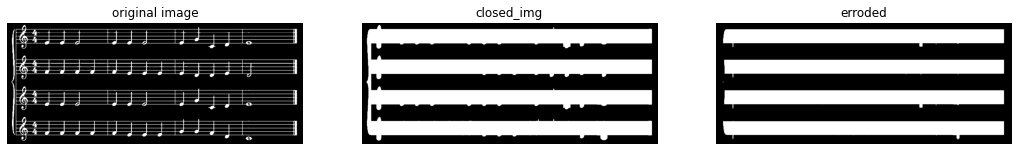

In [43]:
img = io.imread('images/music1.JPG')
img = rgb2gray(img)
img = binarize(img)
img = 255 - img
rows=17
cols=20
selem = rect(rows,cols)
closed_img = binary_closing(img,selem=selem)

selem = rect(3,20)
erroded_img = binary_erosion(closed_img,selem=selem)
show_images([img,closed_img,erroded_img],['original image','closed_img','erroded'])

5
15.47867298578199
15.604316546762595
0.37500000000000167
15.238875878220146
15.120370370370365
[[32.8, 1339.2, 27.8, 112.2], [37.8, 1339.2, 170.8, 254.2], [37.8, 1339.2, 312.8, 398.2], [32.8, 1339.2, 454.8, 541.2]]


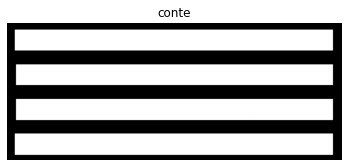

In [54]:
## let's find the contours
m = (4,4000)
conte = np.zeros(erroded_img.shape)
#When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes
# print(bounding_boxes)
bounding_boxes = get_bounding_boxes(erroded_img,(4,4000))
print(bounding_boxes)
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=closed_card2.shape)
    rr = rr.astype(np.int)
    cc= cc.astype(np.int)
    conte[rr, cc] = 1 #set color white

show_images([conte], ['conte'])